In [28]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("birdy654/cifake-real-and-ai-generated-synthetic-images")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\masar\.cache\kagglehub\datasets\birdy654\cifake-real-and-ai-generated-synthetic-images\versions\3


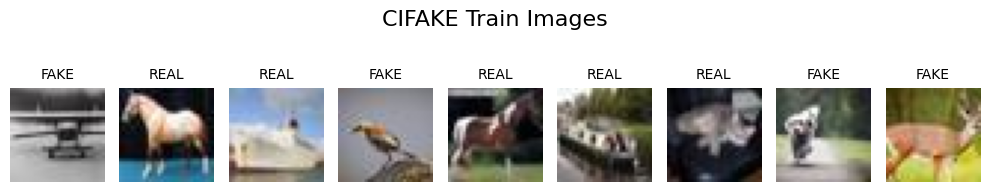

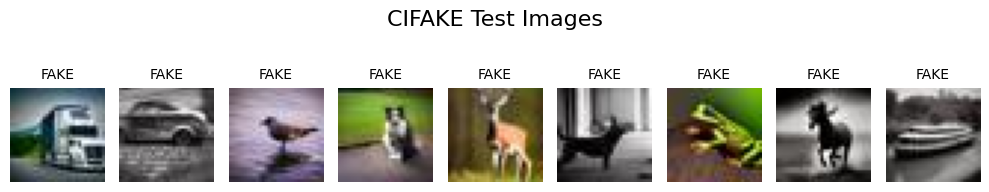

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os

from modules import utils
from modules import globals
# Define some parameters for loading the dataset
img_height = 32
img_width = 32
batch_size = 32

# Define transformations for the images
# We'll normalize the images to the range [0, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Optional: Normalize to [-1, 1]
])

# Load the training dataset
train_dataset = torchvision.datasets.ImageFolder(
    root=os.path.join(globals.DATASET_PATH, 'train'),
    transform=transform
)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0 # You might increase this for faster loading if you have multiple CPU cores
)

# Load the test dataset
test_dataset = torchvision.datasets.ImageFolder(
    root=os.path.join(globals.DATASET_PATH, 'test'),
    transform=transform
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False, # No need to shuffle the test set for visualization
    num_workers=0
)

utils.plot_sample(train_loader, "Train")
utils.plot_sample(test_loader, "Test")